### Imports

In [1]:
import os
import torch
from pytorch3d.io import load_obj, save_obj
from pytorch3d.structures import Meshes, Pointclouds
from pytorch3d.utils import ico_sphere
from pytorch3d.ops import sample_points_from_meshes
import numpy as np
from tqdm.notebook import tqdm
%matplotlib notebook 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80

# Set the device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

### Ground truth map mesh

In [2]:
verts, faces, aux = load_obj(os.path.join('../data/meshes/simple_cave_01.obj'))

# verts is a FloatTensor of shape (V, 3) where V is the number of vertices in the mesh
# faces is an object which contains the following LongTensors: verts_idx, normals_idx and textures_idx
# For this tutorial, normals and textures are ignored.
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

# We construct a Meshes structure for the target mesh
meshes = Meshes(verts=[verts], faces=[faces_idx])

### Point cloud to compare

In [3]:
def plot_pointcloud(inputs, title=""):
    assert isinstance(inputs, Meshes) or isinstance(inputs, Pointclouds) or isinstance(inputs, torch.Tensor)
    if isinstance(inputs, Meshes):
        # Sample points uniformly from the surface of the mesh.
        points = sample_points_from_meshes(inputs, 5000)
    elif isinstance(inputs, Pointclouds):
        points = inputs.points_list()[0]
    elif isinstance(inputs, torch.Tensor):
        points = inputs
    x, y, z = points.clone().detach().cpu().squeeze().unbind(1)    
    fig = plt.figure(figsize=(5, 5))
    ax = Axes3D(fig)
    ax.scatter3D(x, z, -y)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(190, 30)
    plt.show()

In [4]:
# points = sample_points_from_meshes(map_gt_mesh, 5000)
points = verts[None][:, torch.randint(verts.shape[0], (5000,)), :]
pcls = Pointclouds(points)

<IPython.core.display.Javascript object>


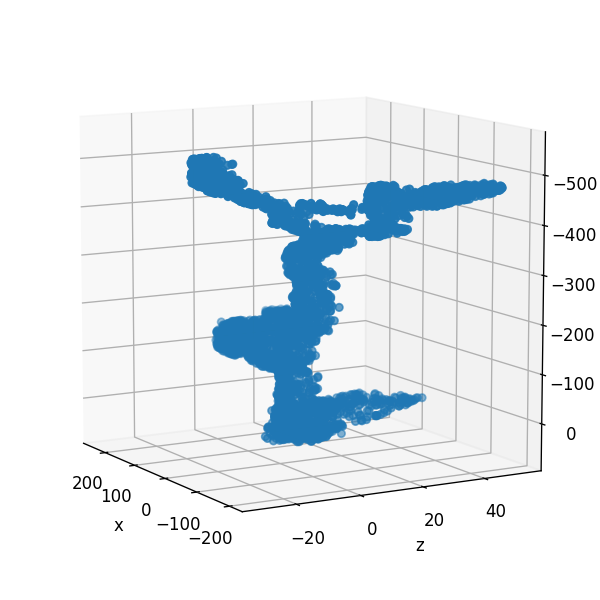

In [5]:
plot_pointcloud(meshes)

<IPython.core.display.Javascript object>


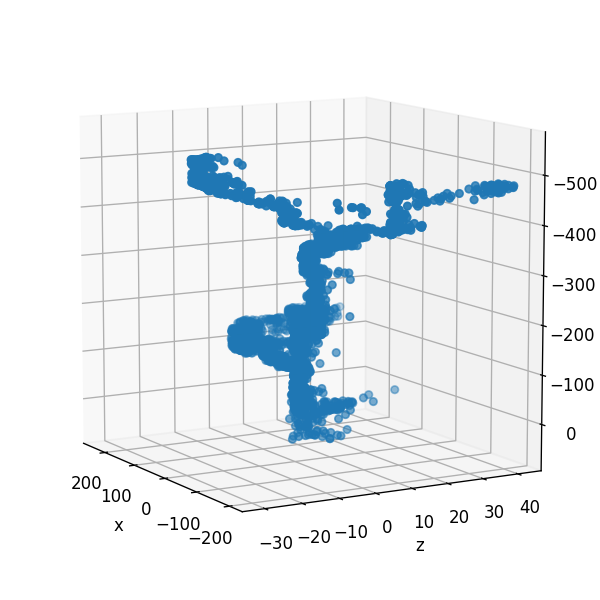

In [6]:
plot_pointcloud(pcls)

### Compare mesh to point cloud

In [7]:
# Compare mesh and point cloud:
# https://pytorch3d.readthedocs.io/en/latest/modules/loss.html#pytorch3d.loss.point_mesh_edge_distance
from pytorch3d.loss import point_mesh_edge_distance, point_mesh_face_distance
from rpz_planning import point_face_distance_truncated
from rpz_planning import point_edge_distance_truncated
from rpz_planning import face_point_distance_truncated
from rpz_planning import edge_point_distance_truncated
from rpz_planning import chamfer_distance_truncated

In [8]:
# point cloud is simply obtained from mesh vertices
with torch.no_grad():
    for s in range(50, 5051, 1000):
        points = verts[None][:, torch.randint(verts.shape[0], (s,)), :]
        pcls = Pointclouds(points)
        print('Num sampled points:', s)
        print('EP:', edge_point_distance_truncated(meshes=meshes, pcls=pcls))
        print('PE:', point_edge_distance_truncated(meshes=meshes, pcls=pcls))
        print('EPPE:', point_mesh_edge_distance(meshes=meshes, pcls=pcls).sqrt())
        print('\n')

        print('FP:', face_point_distance_truncated(meshes=meshes, pcls=pcls))
        print('PF:', point_face_distance_truncated(meshes=meshes, pcls=pcls))
        print('FPPF:', point_mesh_face_distance(meshes=meshes, pcls=pcls).sqrt())
        print('-'*30)

Num sampled points: 50
EP: tensor(18.5304, device='cuda:0')
PE: tensor(0., device='cuda:0')
EPPE: tensor(24.6715, device='cuda:0')


FP: tensor(18.4694, device='cuda:0')
PF: tensor(0., device='cuda:0')
FPPF: tensor(24.6306, device='cuda:0')
------------------------------
Num sampled points: 1050
EP: tensor(2.2265, device='cuda:0')
PE: tensor(0., device='cuda:0')
EPPE: tensor(3.0673, device='cuda:0')


FP: tensor(2.1596, device='cuda:0')
PF: tensor(2.0981e-11, device='cuda:0')
FPPF: tensor(2.9922, device='cuda:0')
------------------------------
Num sampled points: 2050
EP: tensor(1.5183, device='cuda:0')
PE: tensor(0., device='cuda:0')
EPPE: tensor(2.1529, device='cuda:0')


FP: tensor(1.4554, device='cuda:0')
PF: tensor(1.4888e-11, device='cuda:0')
FPPF: tensor(2.0775, device='cuda:0')
------------------------------
Num sampled points: 3050
EP: tensor(1.2432, device='cuda:0')
PE: tensor(3.0535e-13, device='cuda:0')
EPPE: tensor(1.8258, device='cuda:0')


FP: tensor(1.1812, device='cuda

In [17]:
# point cloud is sampled from mesh surface
with torch.no_grad():
    for s in range(50, 5051, 1000):
        points = sample_points_from_meshes(meshes, s)
        pcls = Pointclouds(points)
        print('Num sampled points:', s)
        print('EP:', edge_point_distance_truncated(meshes=meshes, pcls=pcls))
        print('PE:', point_edge_distance_truncated(meshes=meshes, pcls=pcls))
        print('EPPE:', point_mesh_edge_distance(meshes=meshes, pcls=pcls).sqrt())
        print('\n')

        print('FP:', face_point_distance_truncated(meshes=meshes, pcls=pcls))
        print('PF:', point_face_distance_truncated(meshes=meshes, pcls=pcls))
        print('FPPF:', point_mesh_face_distance(meshes=meshes, pcls=pcls).sqrt())
        print('-'*30)

Num sampled points: 50
EP: tensor(17.7564, device='cuda:0')
PE: tensor(0.1928, device='cuda:0')
EPPE: tensor(21.3439, device='cuda:0')


FP: tensor(17.6786, device='cuda:0')
PF: tensor(4.0361e-06, device='cuda:0')
FPPF: tensor(21.2746, device='cuda:0')
------------------------------
Num sampled points: 1050
EP: tensor(3.4018, device='cuda:0')
PE: tensor(0.2098, device='cuda:0')
EPPE: tensor(3.8730, device='cuda:0')


FP: tensor(3.3449, device='cuda:0')
PF: tensor(3.7291e-06, device='cuda:0')
FPPF: tensor(3.8070, device='cuda:0')
------------------------------
Num sampled points: 2050
EP: tensor(2.3691, device='cuda:0')
PE: tensor(0.2015, device='cuda:0')
EPPE: tensor(2.7233, device='cuda:0')


FP: tensor(2.3130, device='cuda:0')
PF: tensor(3.5471e-06, device='cuda:0')
FPPF: tensor(2.6535, device='cuda:0')
------------------------------
Num sampled points: 3050
EP: tensor(1.8811, device='cuda:0')
PE: tensor(0.2056, device='cuda:0')
EPPE: tensor(2.1841, device='cuda:0')


FP: tensor(1.82

### Using Trimesh library

In [75]:
import trimesh

mesh = trimesh.load('../data/meshes/simple_cave_01.obj')

In [54]:
from time import time

for s in range(1000, 10_001, 1000):
    t0 = time()
    # find the closest point on the mesh to each random point
    (closest_points,
    distances,
    triangle_id) = mesh.nearest.on_surface(mesh.vertices[np.random.choice(len(mesh.vertices), s)])
    print(f'For N vertices {s}, computation took {(time()-t0):.3f} [sec]')
    print(f'Mean distance: {distances.mean()}')

For N vertices 1000, computation took 0.657 [sec]
Mean distance: 0.0
For N vertices 2000, computation took 0.799 [sec]
Mean distance: 0.0
For N vertices 3000, computation took 0.977 [sec]
Mean distance: 0.0
For N vertices 4000, computation took 1.058 [sec]
Mean distance: 0.0
For N vertices 5000, computation took 1.043 [sec]
Mean distance: 0.0
For N vertices 6000, computation took 1.172 [sec]
Mean distance: 0.0
For N vertices 7000, computation took 1.368 [sec]
Mean distance: 0.0
For N vertices 8000, computation took 1.517 [sec]
Mean distance: 0.0
For N vertices 9000, computation took 1.485 [sec]
Mean distance: 0.0
For N vertices 10000, computation took 1.091 [sec]
Mean distance: 0.0


In [65]:
pts = verts.detach().cpu()[torch.randint(verts.shape[0], (10000,)), :]
closest_points, distances, triangle_id = mesh.nearest.on_surface(pts)
print(distances.mean())

2.0251136216190778e-07
